In [1]:
import Gmsh: gmsh 
using GR 
using LinearAlgebra
using SparseArrays 
using Plots
using LaTeXStrings
using LinearAlgebra
using SparseArrays 
using StructArrays
using StaticArrays
using StaticRanges
using FastGaussQuadrature
using IterativeSolvers
using Preconditioners
using LinearSolve
using BenchmarkTools
using Profile
using ProfileView
using IncompleteLU
using Plots 

/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/reus3111/snap/code/common/.cache/gio-modules/libgiolibproxy.so
/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/reus3111/snap/code/common/.cache/gio-modules/libgiolibproxy.so


In [2]:
#..1/4: initialize gmsh 
gmsh.initialize()

#..2/4: generate geometry 
gmsh.option.setNumber("General.Terminal", 1)
gmsh.model.add("square")
#..set mesh density parameter 
lc = .01
#..define four points via (x,y,z) coordinates 
gmsh.model.geo.addPoint(0, 0, 0, lc, 1)
gmsh.model.geo.addPoint(1., 0,  0, lc, 2)
gmsh.model.geo.addPoint(1., 1., 0, lc, 3)
gmsh.model.geo.addPoint(0, 1., 0, lc, 4)
#..define four edges by connecting point labels pairwise  
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 1, 4)
#..define curved loop by connecting four edge labels  
gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
#..define surface by curved loop 
gmsh.model.geo.addPlaneSurface([1], 1)
#..give label to the surface 
#..syntax of the function being used is gmsh.model.setPhysicalName(dim, tag, name) 
gmsh.model.setPhysicalName(2, 1, "My surface")
#..synchronize model 
gmsh.model.geo.synchronize()

#..3/4: generate two-dimensional mesh 
gmsh.model.mesh.generate(2)
#..if true, write mesh to file for further processing 
if (true) gmsh.write("square.msh") end 
#..if true, visualize mesh through the GUI 
if (false) gmsh.fltk.run() end 

#..4/4: finalize gmsh 
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000748585s, CPU 0.000297s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.27441s, CPU 0.264961s)
Info    : 11833 nodes 23668 elements
Info    : Writing 'square.msh'...
Info    : Done writing 'square.msh'


In [3]:
#..1/4: Finalize gmsh
gmsh.initialize()

#..2/4: Read mesh from file
gmsh.open("square.msh")

#..3/4: perform loop over the elemements 
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
nelements = length(element_ids[1])
  
for element_id in 1:nelements

    #....retrieve global numbering of the local nodes of the current element
    node1_id = element_connectivity[1][3*(element_id-1)+1]
    node2_id = element_connectivity[1][3*(element_id-1)+2]
    node3_id = element_connectivity[1][3*(element_id-1)+3]

    if (false)
      println("on element ", element_id, " node-1 has global number ", node1_id)
      println("on element ", element_id, " node-2 has global number ", node2_id)
      println("on element ", element_id, " node-3 has global number ", node3_id)
      println(" ")
    end 

end 

#..4/4: Finalize gmsh
gmsh.finalize()

Info    : Reading 'square.msh'...
Info    : 9 entities
Info    : 11833 nodes
Info    : 23668 elements
Info    : Done reading 'square.msh'


In [4]:
function area_triangle(x1,x2,x3,y1,y2,y3)
    x12 = x2 - x1; x13 = x3-x1;
    y12 = y2 - y1; y13 = y3-y1;
    area_id = x12*y13 - x13*y12; 
    area_id = abs(area_id)/2
    return area_id 
end

area_triangle (generic function with 1 method)

In [5]:
#..1/12: Finalize gmsh
gmsh.initialize()

#..2/12: Generate the mesh
gmsh.open("square.msh")

#..3/12 Get and sort the mesh nodes
#..Observe that although the mesh is two-dimensional,
#..the z-coordinate that is equal to zero is stored as well.
#..Observe that the coordinates are stored contiguously for computational
#..efficiency
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
nnodes = length(node_ids)
#..sort the node coordinates by ID, such that Node one sits at row 1
tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
sorted = sortslices(tosort , dims = 1);
node_ids = sorted[:,1]
xnode = sorted[:,2]
ynode = sorted[:,3]

#..4/12 Get the mesh elements
#..observe that we get all the two-dimensional triangular elements from the mesh
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
nelements = length(element_ids[1])

#..5/12 Define the source function and apply the source function to the local coordinates
sourcefunction(x,y) = x+y
fvalues = map(sourcefunction, xnode, ynode)

#..6/12 Initialize global matrix A and global vector f
#..observe that for simplicity we use dense matrix here
A = zeros(nnodes,nnodes)
M = zeros(nnodes,nnodes)
f = zeros(nnodes,1)

#..7/12 Perform a loop over the elements
for element_id in 1:nelements

  #....retrieve global numbering of the local nodes of the current element
  node1_id = element_connectivity[1][3*(element_id-1)+1]
  node2_id = element_connectivity[1][3*(element_id-1)+2]
  node3_id = element_connectivity[1][3*(element_id-1)+3]
  I = Vector{Int64}([node1_id; node2_id; node3_id])

  #....retrieve the x and y coordinates of the local nodes of the current element
  xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
  ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];

  #....compute surface area of the current element
  area_id = area_triangle(xnode1,xnode2,xnode3,ynode1,ynode2,ynode3)

  #....if desired, print global number numbers and element area to screen
  if (false)
    println("on element ", element_id, " node-1 has global number ", node1_id)
    println("on element ", element_id, " node-2 has global number ", node2_id)
    println("on element ", element_id, " node-3 has global number ", node3_id)
    println("on element ", element_id, " area = ", area_id)
    println(" ")
  end
    
  #....compute local vector contribution floc of the current element
  floc = area_id/3*fvalues[I]

  #....compute local matrix contribution Aloc of the current element
  Emat = [[xnode1;xnode2;xnode3] [ynode1;ynode2;ynode3] [1;1;1]]\UniformScaling(1.);
  Emat[3,:] .= 0;
  Aloc = area_id*(transpose(Emat)*Emat);
  Mloc = area_id/3*[1 0 0; 0 1 0; 0 0 1]; 
    
  #....perform loop over nodes of the current element
  #....and add local contribution Aloc to global matrix entity A
  f[I] += floc
  A[I,I] += Aloc
  M[I,I] += Mloc

end

#..8/12 Handle the boundary conditions
#..retrieve boundary nodes by loop over corner point and boundary edges
node_ids1=[]; node_ids2=[]; node_ids3=[]; node_ids4=[]; 
node_ids5=[]; node_ids6=[]; node_ids7=[]; node_ids8=[]; 
node_ids1, node_coord, _ = gmsh.model.mesh.getNodes(0,1)
node_ids2, node_coord, _ = gmsh.model.mesh.getNodes(0,2)
node_ids3, node_coord, _ = gmsh.model.mesh.getNodes(0,3)
node_ids4, node_coord, _ = gmsh.model.mesh.getNodes(0,4)
node_ids5, node_coord, _ = gmsh.model.mesh.getNodes(1,1)
node_ids6, node_coord, _ = gmsh.model.mesh.getNodes(1,2)
node_ids7, node_coord, _ = gmsh.model.mesh.getNodes(1,3)
node_ids8, node_coord, _ = gmsh.model.mesh.getNodes(1,4)
bnd_node_ids = union(node_ids1,node_ids2,node_ids3,node_ids4,node_ids5,node_ids6,node_ids7,node_ids8)
A[bnd_node_ids,:] .= 0;
A[bnd_node_ids,bnd_node_ids] = Diagonal(ones(size(bnd_node_ids)))
f[bnd_node_ids] .= 0;

#..9/12 Make A sparse and M diagonal 
A = sparse(A)
M = Diagonal(M)

#..10/12 Compute the numerical solution
u = A \ f

#..10/12: Finalize gmsh
gmsh.finalize()

#..11/12 Plot the numerical solution
GR.trisurf(xnode,ynode,u)

display(A)
print(size(f)[1])

11833×11833 SparseMatrixCSC{Float64, Int64} with 80428 stored entries:
⎡⣑⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⠀⡀⣀⡀⡀⣀⣀⎤
⎢⠉⠉⡿⣯⣷⠄⢺⣾⠃⠵⠀⣴⣿⡋⡏⣏⠄⣘⣐⣅⣐⠀⢕⠹⣿⣛⣽⣯⣿⣽⣿⣿⣿⣫⣯⠶⣿⣿⡯⠉⎥
⎢⠀⠀⠙⠟⣿⣿⣾⣿⣗⠺⠂⢿⣿⢸⡯⡟⢲⠁⢹⡿⢻⠰⠂⢘⣽⣿⣽⣯⣿⣿⣿⣿⣿⣯⣿⣿⣽⡝⡊⠀⎥
⎢⠀⠀⣺⣶⣾⣿⣿⣿⣯⣦⡰⣿⣿⣼⡃⡷⢼⡃⡾⣏⢒⠠⠶⠸⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⣿⣷⣗⠀⎥
⎢⠀⠀⢍⡄⣹⡙⠫⣿⣿⣿⣧⣿⣾⣽⣦⣎⢼⠏⢶⡍⢂⢔⣨⢨⣽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⠏⠀⎥
⎢⠀⠀⢀⣤⣬⣄⣴⣮⣭⣿⠿⣧⣻⣿⣿⣿⣿⡣⣯⡏⠑⣠⠄⢰⣯⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⣷⠷⠀⎥
⎢⠀⠀⡿⠻⣛⣛⣛⣿⣞⣿⣿⣾⣿⣿⣿⣿⣿⣧⣿⣿⣮⣒⢿⢘⣿⣿⣿⣻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡧⠀⎥
⎢⠀⠀⡯⢭⣯⠯⢭⡬⡨⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣾⣿⢸⣿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣑⎥
⎢⠀⠀⣀⢡⠜⠒⠶⠳⡶⠗⠿⡻⠿⣿⣿⣿⣿⣿⣿⣿⣷⣿⣿⣝⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣾⣮⣨⎥
⎢⠀⠀⠔⢼⣷⡶⡾⢯⡜⠷⡯⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡢⎥
⎢⠀⠀⠐⠘⢛⡒⠘⡐⢈⢔⠑⣠⢪⢻⣻⣿⣽⣿⣿⣿⣻⣾⣿⣿⣿⣿⣻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡍⎥
⎢⢄⣠⣕⡑⣈⢀⣘⡃⡂⣚⢀⣁⣛⢓⣛⣛⣟⢿⣿⣿⣿⣿⡻⣮⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣻⣿⣶⎥
⎢⢶⣿⣿⢻⣷⣿⣿⣿⣷⣿⣯⣿⣿⣿⣿⣟⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣼⣿⡷⣿⡷⣿⣿⣿⣿⣿⣿⣿⣿⣻⣿⣿⣿⣿⣿⣿⣿⣾⣿⣿⣿⣿⣿⣿⣿⣿⣾⣿⣿⣿⣿⣿⣿⣿⢿⣿⎥
⎢⡫⣻⣟⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⎥
⎢⠋⠙⡿⣻⡿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⎥
⎢⢁⢩⢫⡟⣿⣿⣿⡿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣾⣿⣭⡫⎥
⎢⠀⠩⣿⣿⣗⠿⢿⣿⣿⢿⢿⣯⣿⣿⣿⣿⣻⣿⣿⣿⣿⣿⣿⣻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣾⣿⣿⣿⡿⠫⎥
⎣⣴⣿⡏⠋⠊⠈⠙⠙⠋⠁⠙⠃⠉⠋⢟⢻⡊⣻⠹⡻⡝⠿⢻⣿⣿⣿⣿⣷⣿⣿⣿⡿⢿⣿⡧⡻⡿⡋⢿⣷⎦

Info    : Reading 'square.msh'...
Info    : 9 entities
Info    : 11833 nodes
Info    : 23668 elements
Info    : Done reading 'square.msh'
11833

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000152591s, CPU 0.000144s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.000177542s, CPU 0.000166s)
Info    : 12 nodes 26 elements
Info    : Writing 'square.msh'...
Info    : Done writing 'square.msh'
Info    : Reading 'square.msh'...
Info    : 9 entities
Info    : 12 nodes
Info    : 26 elements
Info    : Done reading 'square.msh'
Info    : Reading 'square.msh'...
Info    : 9 entities
Info    : 12 nodes
Info    : 26 elements
Info    : Done reading 'square.msh'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000158496s, CPU 0.000155s)
Info  

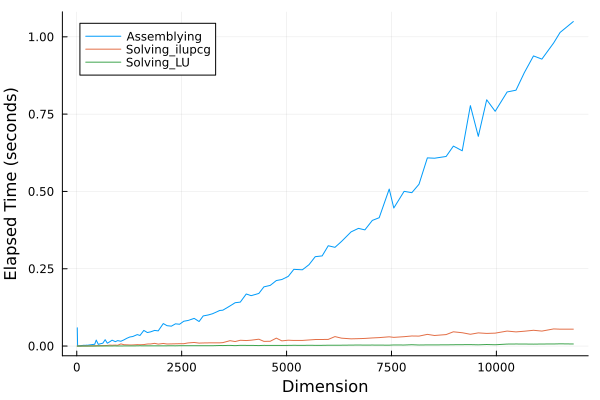

In [6]:
function LU_pre(m)
    return lu(m)
end

function LU_calc(lu, f)
    return lu\f
end

function backslash(m::Tridiagonal{Float64, Vector{Float64}}, f::Vector{Float64})
    return m\f
end

function solve_and_write_time(n)
    
    ret = zeros(4);
    gmsh.initialize()

    #..2/4: generate geometry 
    gmsh.option.setNumber("General.Terminal", 1)
    gmsh.model.add("square")
    #..set mesh density parameter 
    lc = 1/n
    #..define four points via (x,y,z) coordinates 
    gmsh.model.geo.addPoint(0, 0, 0, lc, 1)
    gmsh.model.geo.addPoint(1., 0,  0, lc, 2)
    gmsh.model.geo.addPoint(1., 1., 0, lc, 3)
    gmsh.model.geo.addPoint(0, 1., 0, lc, 4)
    #..define four edges by connecting point labels pairwise  
    gmsh.model.geo.addLine(1, 2, 1)
    gmsh.model.geo.addLine(2, 3, 2)
    gmsh.model.geo.addLine(3, 4, 3)
    gmsh.model.geo.addLine(4, 1, 4)
    #..define curved loop by connecting four edge labels  
    gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
    #..define surface by curved loop 
    gmsh.model.geo.addPlaneSurface([1], 1)
    #..give label to the surface 
    #..syntax of the function being used is gmsh.model.setPhysicalName(dim, tag, name) 
    gmsh.model.setPhysicalName(2, 1, "My surface")
    #..synchronize model 
    gmsh.model.geo.synchronize()

    #..3/4: generate two-dimensional mesh 
    gmsh.model.mesh.generate(2)
    #..if true, write mesh to file for further processing 
    if (true) gmsh.write("square.msh") end 
    #..if true, visualize mesh through the GUI 
    if (false) gmsh.fltk.run() end 

    # Measure the time to assembly the linear system
    elapsed_time_assembly = @elapsed begin
        #..1/4: initialize gmsh 
        
        #..2/4: Read mesh from file
        gmsh.open("square.msh")

        #..3/4: perform loop over the elemements 
        element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
        nelements = length(element_ids[1])
        
        for element_id in 1:nelements

            #....retrieve global numbering of the local nodes of the current element
            node1_id = element_connectivity[1][3*(element_id-1)+1]
            node2_id = element_connectivity[1][3*(element_id-1)+2]
            node3_id = element_connectivity[1][3*(element_id-1)+3]

            if (false)
            println("on element ", element_id, " node-1 has global number ", node1_id)
            println("on element ", element_id, " node-2 has global number ", node2_id)
            println("on element ", element_id, " node-3 has global number ", node3_id)
            println(" ")
            end 

        end 

        #..2/12: Generate the mesh
        gmsh.open("square.msh")

        #..3/12 Get and sort the mesh nodes
        #..Observe that although the mesh is two-dimensional,
        #..the z-coordinate that is equal to zero is stored as well.
        #..Observe that the coordinates are stored contiguously for computational
        #..efficiency
        node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
        nnodes = length(node_ids)
        #..sort the node coordinates by ID, such that Node one sits at row 1
        tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
        sorted = sortslices(tosort , dims = 1);
        node_ids = sorted[:,1]
        xnode = sorted[:,2]
        ynode = sorted[:,3]

        #..4/12 Get the mesh elements
        #..observe that we get all the two-dimensional triangular elements from the mesh
        element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
        nelements = length(element_ids[1])

        #..5/12 Define the source function and apply the source function to the local coordinates
        sourcefunction(x,y) = x+y
        fvalues = map(sourcefunction, xnode, ynode)

        #..6/12 Initialize global matrix A and global vector f
        #..observe that for simplicity we use dense matrix here
        A = zeros(nnodes,nnodes)
        M = zeros(nnodes,nnodes)
        f = zeros(nnodes,1)

        #..7/12 Perform a loop over the elements
        for element_id in 1:nelements

        #....retrieve global numbering of the local nodes of the current element
        node1_id = element_connectivity[1][3*(element_id-1)+1]
        node2_id = element_connectivity[1][3*(element_id-1)+2]
        node3_id = element_connectivity[1][3*(element_id-1)+3]
        I = Vector{Int64}([node1_id; node2_id; node3_id])

        #....retrieve the x and y coordinates of the local nodes of the current element
        xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
        ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];

        #....compute surface area of the current element
        area_id = area_triangle(xnode1,xnode2,xnode3,ynode1,ynode2,ynode3)

        #....if desired, print global number numbers and element area to screen
        if (false)
            println("on element ", element_id, " node-1 has global number ", node1_id)
            println("on element ", element_id, " node-2 has global number ", node2_id)
            println("on element ", element_id, " node-3 has global number ", node3_id)
            println("on element ", element_id, " area = ", area_id)
            println(" ")
        end
            
        #....compute local vector contribution floc of the current element
        floc = area_id/3*fvalues[I]

        #....compute local matrix contribution Aloc of the current element
        Emat = [[xnode1;xnode2;xnode3] [ynode1;ynode2;ynode3] [1;1;1]]\UniformScaling(1.);
        Emat[3,:] .= 0;
        Aloc = area_id*(transpose(Emat)*Emat);
        Mloc = area_id/3*[1 0 0; 0 1 0; 0 0 1]; 
            
        #....perform loop over nodes of the current element
        #....and add local contribution Aloc to global matrix entity A
        f[I] += floc
        A[I,I] += Aloc
        M[I,I] += Mloc
        end

        #..8/12 Handle the boundary conditions
        #..retrieve boundary nodes by loop over corner point and boundary edges
        node_ids1=[]; node_ids2=[]; node_ids3=[]; node_ids4=[]; 
        node_ids5=[]; node_ids6=[]; node_ids7=[]; node_ids8=[]; 
        node_ids1, node_coord, _ = gmsh.model.mesh.getNodes(0,1)
        node_ids2, node_coord, _ = gmsh.model.mesh.getNodes(0,2)
        node_ids3, node_coord, _ = gmsh.model.mesh.getNodes(0,3)
        node_ids4, node_coord, _ = gmsh.model.mesh.getNodes(0,4)
        node_ids5, node_coord, _ = gmsh.model.mesh.getNodes(1,1)
        node_ids6, node_coord, _ = gmsh.model.mesh.getNodes(1,2)
        node_ids7, node_coord, _ = gmsh.model.mesh.getNodes(1,3)
        node_ids8, node_coord, _ = gmsh.model.mesh.getNodes(1,4)
        bnd_node_ids = union(node_ids1,node_ids2,node_ids3,node_ids4,node_ids5,node_ids6,node_ids7,node_ids8)
        A[bnd_node_ids,:] .= 0;
        A[bnd_node_ids,bnd_node_ids] = Diagonal(ones(size(bnd_node_ids)))
        f[bnd_node_ids] .= 0;

        #..9/12 Make A sparse and M diagonal 
        A = sparse(A)
        M = Diagonal(M)

        #..10/12: Finalize gmsh
        gmsh.finalize()

    end
    ret[1] = elapsed_time_assembly

    #Measure the time to solve the linear system with the cg method
    
    elapsed_time_solving = @elapsed begin
        preconditioner = ilu(A)
        x = cg(A, f, Pl=preconditioner)
    end
    ret[2] = elapsed_time_solving

    #=#Measure the time to solve the linear system with the MINRES algorithm
    elapsed_time_minres = @elapsed begin
        abstol=1e-14
        x=minres(A,f,maxiter=200,abstol=abstol)
    end
    ret[4] = elapsed_time_minres
    =#
    #Measure the time to solve the linear system with the LU decomposition and \ operator
    A=Tridiagonal(A)
    
    elapsed_time_LU = @elapsed begin
        luMat = LU_pre(A)
        x = LU_calc(luMat, f)
    end
    ret[3]=elapsed_time_LU
    ret[4] = size(f)[1]

    return ret
end

# Set the dimensions for the loop (e.g., from 2 to 100000 with a step of 1000)
dimensions = 2:1:100
times_assembly = []
times_solving = []
times_LU = []
dim = []
#times_minres = []
# Solve linear systems and collect elapsed times
for n in dimensions
    time = solve_and_write_time(n)
    push!(times_assembly, time[1])
    push!(times_solving, time[2])
    push!(times_LU,time[3])
    push!(dim,time[4])
    #push!(times_minres,time[4])
end

# Plot the graph
Plots.plot(dim, times_assembly, xlabel="Dimension", ylabel="Elapsed Time (seconds)", label="Assemblying", legend=:topleft)
Plots.plot!(dim, times_solving, label="Solving_ilupcg")
Plots.plot!(dim, times_LU, label="Solving_LU")
#plot!(dimensions,times_minres, label="Solving MINRES")